<a href="https://colab.research.google.com/github/jeffersonscampos/Artificial-Intelligence_Data-Science_Machine-Learning/blob/master/ML_Pocos_Petroleo_Interpolacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Previsão em Poços de petróleo</center>

In [0]:
!pip install lasio

## 1 - Definição do Problema

Esse projeto tem o objetivo de fazer a previsão de variáveis a partir de dados de poços de petróleo.

Os dados utilizados nesse projeto foram gerados de forma sintética pelo LAS - UNICAMP

O Problema a ser tratado pode ser dividido em 2 sub problemas
- Previsão da variável PERMEABILITY, a partir das demais variáveis da base de dados
- Previsão da variável POROSITY, a partir das demais variáveis da base de dados

Em ambos os casos, os problemas devem ser tratados como problemas de regressão, pois ambas as variáveis a serem preditas são variáveis contínuas.


## 2 - Carga dos Dados

In [0]:
# imports
import numpy as np 
import pandas as pd
import lasio #biblioteca utilizada para a leitura dos dados

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error

In [0]:
# os dados são lidos e carregados em um Dataframe chamado df
las1 = lasio.read('dados/inj_1')
df = pd.DataFrame(las1.data, columns = las1.keys())
df.head()

,DEPT,ESTIMATEDLOG,PERMEABILITY,POROSITY,UCF_D,PERMEABILITY_Z,INTENSITY
0,3410.438497,NaN,240.951645,0.140528,1.0,9.638065,0.002880
1,3412.634966,NaN,240.951645,0.140528,1.0,9.638065,0.002880
2,3412.637165,NaN,261.061340,0.204155,1.0,10.442453,0.002619
3,3414.831979,NaN,261.061340,0.204155,1.0,10.442453,0.002619
4,3414.834176,NaN,280.989838,0.193558,1.0,11.239594,0.005349


## 3 - Análise Exploratória dos dados

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df.shape

(165, 7)

A base de dados possui 165 registros e 7 colunas.

In [0]:
# Tipos de Dados
df.dtypes

DEPT              float64
ESTIMATEDLOG      float64
PERMEABILITY      float64
POROSITY          float64
UCF_D             float64
PERMEABILITY_Z    float64
INTENSITY         float64
dtype: object

Todos os valores são do tipo float

In [0]:
# Verificando valores missing
print(df.isna().sum())

DEPT                0
ESTIMATEDLOG      165
PERMEABILITY        1
POROSITY            1
UCF_D               1
PERMEABILITY_Z      1
INTENSITY           1
dtype: int64


Analisando-se a existência de valores faltantes, chegou-se as seguintes conclusões:
- A Coluna "DEPT" não possui nenhum valor faltante.
- As colunas "PERMEABILITY", "POROSITY", "UCF_D", "PERMEABILITY_Z" e "INTENSITY" possuem apenas 1 valor faltante.
- A coluna "ESTIMATEDLOG" possui todos os valores faltantes, logo, tal coluna deve ser eliminada, pois ela não irá trazer nenhum ganho para o processo..

In [0]:
#retiranda da variável ESTIMATEDLOG da base de dados
df.drop('ESTIMATEDLOG', axis=1, inplace=True)
df.head()

,DEPT,PERMEABILITY,POROSITY,UCF_D,PERMEABILITY_Z,INTENSITY
0,3410.438497,240.951645,0.140528,1.0,9.638065,0.002880
1,3412.634966,240.951645,0.140528,1.0,9.638065,0.002880
2,3412.637165,261.061340,0.204155,1.0,10.442453,0.002619
3,3414.831979,261.061340,0.204155,1.0,10.442453,0.002619
4,3414.834176,280.989838,0.193558,1.0,11.239594,0.005349


Verificação dos demais casos de valores nulos

In [0]:
df[df.PERMEABILITY.isnull()]

,DEPT,PERMEABILITY,POROSITY,UCF_D,PERMEABILITY_Z,INTENSITY
164,3584.78945,NaN,NaN,NaN,NaN,NaN


percebe-se que todos os demais valores nulos estão na mesma linha, logo, esse registro também deve ser eliminado. 

In [0]:
df=df[~df.PERMEABILITY.isnull()]

In [0]:
# Verificando valores missing
print(df.isna().sum())

DEPT              0
PERMEABILITY      0
POROSITY          0
UCF_D             0
PERMEABILITY_Z    0
INTENSITY         0
dtype: int64


In [0]:
df.shape

(164, 6)

Após os tratamentos, a base ficou sem nenhum valor faltante e passou a ter 164 linha e 6 colunas.

In [0]:
# Verificando Valores Únicos
df.nunique()

DEPT              164
PERMEABILITY       67
POROSITY           67
UCF_D               4
PERMEABILITY_Z     67
INTENSITY          82
dtype: int64

Apesar de ser representada por números (1.0, 2.0, 3.0 e 4.0), a variável "UCF_D" é uma variável categórica.

In [0]:
unique, counts = np.unique(df['UCF_D'], return_counts=True)
unique, counts

(array([1., 2., 3., 4.]), array([60, 70, 32,  2]))

Conforme verificado na célula acima, a variável "UCF_D" apresenta a seguinte distribuição de valores:
- Valor 1: 60 ocorrências 
- Valor 2: 70 ocorrências 
- Valor 3: 32 ocorrências 
- Valor 4: 02 ocorrências 

### Análise das variáveis continuas

In [0]:
#aqui, cria-se uma lista para armazenar os nomes das variáveis contínuas 
continuas = list(df.columns)
continuas.remove('UCF_D')
continuas

['DEPT', 'PERMEABILITY', 'POROSITY', 'PERMEABILITY_Z', 'INTENSITY']

Verificação de correlação entre as variáveis

In [0]:
df[continuas].corr()

,DEPT,PERMEABILITY,POROSITY,PERMEABILITY_Z,INTENSITY
DEPT,1.000000,-0.175904,0.029849,-0.175904,-0.274487
PERMEABILITY,-0.175904,1.000000,0.249473,1.000000,0.016798
POROSITY,0.029849,0.249473,1.000000,0.249473,-0.031536
PERMEABILITY_Z,-0.175904,1.000000,0.249473,1.000000,0.016798
INTENSITY,-0.274487,0.016798,-0.031536,0.016798,1.000000


Analisando a tabela de correlações, percebe-se que as variáveis PERMEABILITY e PERMEABILITY_Z
são totalmente correlacionadas (correlação=1). Logo, não há necessidade de se manter essas 2 variáveis na base de dados.

In [0]:
df[['PERMEABILITY','PERMEABILITY_Z']].head()

,PERMEABILITY,PERMEABILITY_Z
0,240.951645,9.638065
1,240.951645,9.638065
2,261.061340,10.442453
3,261.061340,10.442453
4,280.989838,11.239594


In [0]:
df['PERMEABILITY']/df['PERMEABILITY_Z']

0      25.000001
1      25.000001
2      25.000001
3      25.000001
4      25.000000
         ...    
159    25.000000
160    25.000000
161    25.000000
162    25.000000
163    25.000000
Length: 164, dtype: float64

Como pode ser visto, a variável PERMEABILITY sempre é 25 vezes maior que a variável PERMEABILITY_Z (PERMEABILITY = 25 * PERMEABILITY_Z). Como a variável PERMEABILITY é uma das variáveis a serem preditas, optou-se pela retirada da variável PERMEABILITY_Z da base de dados. 

In [0]:
# retirada da variável PERMEABILITY_Z
df.drop('PERMEABILITY_Z', axis=1, inplace=True)
df.head()

,DEPT,PERMEABILITY,POROSITY,UCF_D,INTENSITY
0,3410.438497,240.951645,0.140528,1.0,0.002880
1,3412.634966,240.951645,0.140528,1.0,0.002880
2,3412.637165,261.061340,0.204155,1.0,0.002619
3,3414.831979,261.061340,0.204155,1.0,0.002619
4,3414.834176,280.989838,0.193558,1.0,0.005349


### Verificação de outliers

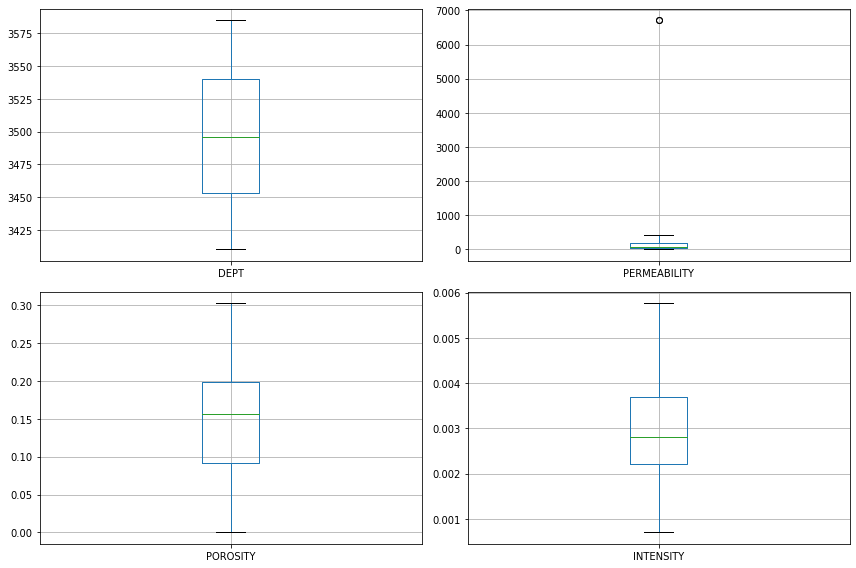

In [0]:
# Plot das variáveis contínuas
continuas.remove('PERMEABILITY_Z')
# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i, col in enumerate(continuas):
    plt.subplot(2, 2, i + 1);
    df.boxplot(col);
    plt.tight_layout()
    

Analisando-se os Boxplots acima, percebe-se que a variável PERMEABILITY possui um outlier

In [0]:
df['PERMEABILITY'].quantile(0.25)

44.000728607

In [0]:
Q1 = df.PERMEABILITY.quantile(0.25)
Q2 = df.PERMEABILITY.quantile(0.5)
Q3 = df.PERMEABILITY.quantile(0.75)
IQR = Q3 - Q1
print("O valor do 1º quartil é {}, o do 2º quartil (mediana) é {} e do 3º quartil é {}".format(Q1, Q2, Q3))
print("\nO intervalo inter quartil é {}".format(IQR))
#df['PERMEABILITY']=df[~((df.PERMEABILITY < (Q1 - 1.5 * IQR)) | (df.PERMEABILITY > (Q3 + 1.5 * IQR)))]['PERMEABILITY']
print('\n\n Os outliers são:')
df[((df.PERMEABILITY < (Q1 - 1.5 * IQR)) | (df.PERMEABILITY > (Q3 + 1.5 * IQR)))]['PERMEABILITY']

O valor do 1º quartil é 44.000728607, o do 2º quartil (mediana) é 73.9114723205 e do 3º quartil é 194.5977478

O intervalo inter quartil é 150.597019193


 Os outliers são:


12    6714.733398
13    6714.733398
Name: PERMEABILITY, dtype: float64

Como pode ser observado, os outliers identificados são muito maiores que os demais valores da dessa variável. Esses valores discrepantes também são prejudiciais ao processo de aprendizagem de máquina, e por isso, também devem ser retirados da base de dados.  

In [0]:
df[((df.PERMEABILITY < (Q1 - 1.5 * IQR)) | (df.PERMEABILITY > (Q3 + 1.5 * IQR)))]

,DEPT,PERMEABILITY,POROSITY,UCF_D,INTENSITY
12,3421.410756,6714.733398,0.238339,4.0,0.003097
13,3423.598108,6714.733398,0.238339,4.0,0.003097


In [0]:
Q2

73.9114723205

In [0]:
df=df[~((df.PERMEABILITY < (Q1 - 1.5 * IQR)) | (df.PERMEABILITY > (Q3 + 1.5 * IQR)))]

## 4 - Pré-processamento dos dados

Como verificado na Análise exploratória dos dados, a variável 'UCF_D' apresenta características de uma variável categórica.

In [0]:
unique, counts = np.unique(df['UCF_D'], return_counts=True)
unique, counts

(array([1., 2., 3.]), array([60, 70, 32]))

Ná análise inicial, a variável UCF_D apresentava 4 valores possíveis, no entanto, após a retirada dos registros com outliers, ela passou a possuir apenas 3 valores distintos.

Na análise inicial, a variável UCF_D apresentava 4 valores possíveis, no entanto, após a retirada dos registros com outliers, ela passou a possuir apenas 3 valores distintos.

Após alguns testes, constatou-se que a variável UCF_D é uma variável categórica não ordenável, logo, tais variáveis não podem ser tratadas como números sequencias, pois, o fato de um registro dessa variável estar com o valor 3 não quer dizer que ele seja maior do que um outro registro dessa mesma variável que esteja com o valor 1. Ou seja, a forma como essa variável está sendo representada não é a mais indicada, pois ela acaba sugerindo um tipo de relação entre os registros que na verdade não existe.

Sendo assim, a melhor forma de se representar essa variável é utilizando a representação one-hot encode. Nesse tipo de representação, a distância entre todos os tipos de regitros dessa variável é sempre o mesmo.

Para o caso da variável em questão, a representação poderia ser feita da seguinte forma:
- valor 1: [1, 0, 0]
- valor 2: [0, 1, 0]
- valor 3: [0, 0, 1]

No entanto, uma forma mais compacta de se fazer essa representação seria:
- valor 1: [0, 0]
- valor 2: [1, 0]
- valor 3: [0, 1]

In [0]:
df.head()

,DEPT,PERMEABILITY,POROSITY,UCF_D,INTENSITY
0,3410.438497,240.951645,0.140528,1.0,0.002880
1,3412.634966,240.951645,0.140528,1.0,0.002880
2,3412.637165,261.061340,0.204155,1.0,0.002619
3,3414.831979,261.061340,0.204155,1.0,0.002619
4,3414.834176,280.989838,0.193558,1.0,0.005349


In [0]:
df.shape

(162, 5)

In [0]:
df.head()

,DEPT,PERMEABILITY,POROSITY,UCF_D,INTENSITY
0,3410.438497,240.951645,0.140528,1.0,0.002880
1,3412.634966,240.951645,0.140528,1.0,0.002880
2,3412.637165,261.061340,0.204155,1.0,0.002619
3,3414.831979,261.061340,0.204155,1.0,0.002619
4,3414.834176,280.989838,0.193558,1.0,0.005349


In [0]:
df.tail()

,DEPT,PERMEABILITY,POROSITY,UCF_D,INTENSITY
159,3580.491558,194.597748,0.229282,1.0,0.002523
160,3580.493708,82.377754,0.230196,2.0,0.001158
161,3582.639924,82.377754,0.230196,2.0,0.001158
162,3582.642072,95.544464,0.179122,2.0,0.003157
163,3584.787302,95.544464,0.179122,2.0,0.003157


### Interpolação dos Dados


In [0]:
def interpolar(dfDados, tamanho_interpolacao = 10, coluna = "DEPT"):
  novo_dados = np.linspace(dados[coluna].min(), dfDados[coluna].max(), dfDados.shape[0] * tamanho_interpolacao)
  dfnovo = pd.DataFrame(novo_dados)
  return dfnovo

In [0]:
import scipy.interpolate as interpolate
# Interpolate the data using a cubic spline to "new_length" samples
tamanho_interpolacao = 10
#novo_dados_dept = np.linspace(dados["DEPT"].min(), dados["DEPT"].max(), dados.shape[0] * tamanho_interpolacao)
#dfnovo = pd.DataFrame(novo_dados_dept)
colDEPT = "DEPT"
dfnovo = interpolar(df, tamanho_interpolacao, colDEPT)
dfnovo.shape


(1620, 1)

In [0]:
colPERMEABILITY = "PERMEABILITY"
dfnovo[colPERMEABILITY] = interpolar(df, tamanho_interpolacao, colPERMEABILITY)
dfnovo.shape

(1620, 2)

In [0]:
colPOROSITY = "POROSITY"
dfnovo[colPOROSITY] = interpolar(df, tamanho_interpolacao, colPOROSITY)
dfnovo.shape

(1620, 3)

In [0]:
colUCF_D = "UCF_D"
dfnovo[colUCF_D] = interpolar(df, tamanho_interpolacao, colUCF_D)
dfnovo.shape

(1620, 4)

In [0]:
colINTENSITY = "INTENSITY"
dfnovo[colINTENSITY] = interpolar(df, tamanho_interpolacao, colINTENSITY)
dfnovo.shape

(1620, 5)

In [0]:
dfnovo.columns = [colDEPT, colPERMEABILITY, colPOROSITY, colUCF_D, colINTENSITY]

In [0]:
dfnovo.head()

,DEPT,PERMEABILITY,POROSITY,UCF_D,INTENSITY
0,3410.438497,0.000000,0.000000,1.0,0.000701
1,3410.546186,0.257590,0.000187,1.0,0.000704
2,3410.653876,0.515179,0.000374,1.0,0.000707
3,3410.761565,0.772769,0.000561,1.0,0.000710
4,3410.869254,1.030358,0.000748,1.0,0.000713


In [0]:
df.head()

,DEPT,PERMEABILITY,POROSITY,UCF_D,INTENSITY
0,3410.438497,240.951645,0.140528,1.0,0.002880
1,3412.634966,240.951645,0.140528,1.0,0.002880
2,3412.637165,261.061340,0.204155,1.0,0.002619
3,3414.831979,261.061340,0.204155,1.0,0.002619
4,3414.834176,280.989838,0.193558,1.0,0.005349


In [0]:
df.columns

Index(['DEPT', 'PERMEABILITY', 'POROSITY', 'UCF_D', 'INTENSITY'], dtype='object')

In [0]:
dfnovo.columns

Index(['DEPT', 'PERMEABILITY', 'POROSITY', 'UCF_D', 'INTENSITY'], dtype='object')

In [0]:
df.shape

(162, 5)

In [0]:
dfnovo.shape

(1620, 5)

In [0]:
# trata o arredondamento para a coluna UCF_D valores (0 ou 1)
dfnovo[colUCF_D] = round(dfnovo[colUCF_D], 0)

In [0]:
#transformação da variável UCF_D
df=pd.get_dummies(df,columns=[colUCF_D],drop_first=True)

In [0]:
#transformação da variável UCF_D
dfnovo=pd.get_dummies(dfnovo,columns=['UCF_D'],drop_first=True)

In [0]:
df.head()

,DEPT,PERMEABILITY,POROSITY,INTENSITY,UCF_D_2.0,UCF_D_3.0
0,3410.438497,240.951645,0.140528,0.002880,0,0
1,3412.634966,240.951645,0.140528,0.002880,0,0
2,3412.637165,261.061340,0.204155,0.002619,0,0
3,3414.831979,261.061340,0.204155,0.002619,0,0
4,3414.834176,280.989838,0.193558,0.005349,0,0


In [0]:
dfnovo.head()

,DEPT,PERMEABILITY,POROSITY,INTENSITY,UCF_D_2.0,UCF_D_3.0
0,3410.438497,0.000000,0.000000,0.000701,0,0
1,3410.546186,0.257590,0.000187,0.000704,0,0
2,3410.653876,0.515179,0.000374,0.000707,0,0
3,3410.761565,0.772769,0.000561,0.000710,0,0
4,3410.869254,1.030358,0.000748,0.000713,0,0


In [0]:
df.tail()

,DEPT,PERMEABILITY,POROSITY,INTENSITY,UCF_D_2.0,UCF_D_3.0
159,3580.491558,194.597748,0.229282,0.002523,0,0
160,3580.493708,82.377754,0.230196,0.001158,1,0
161,3582.639924,82.377754,0.230196,0.001158,1,0
162,3582.642072,95.544464,0.179122,0.003157,1,0
163,3584.787302,95.544464,0.179122,0.003157,1,0


In [0]:
dfnovo.tail()

,DEPT,PERMEABILITY,POROSITY,INTENSITY,UCF_D_2.0,UCF_D_3.0
1615,3584.356546,416.007057,0.302090,0.005753,0,1
1616,3584.464235,416.264646,0.302277,0.005756,0,1
1617,3584.571924,416.522236,0.302464,0.005759,0,1
1618,3584.679613,416.779825,0.302651,0.005763,0,1
1619,3584.787302,417.037415,0.302838,0.005766,0,1


# 5 - Geração dos Modelos

## Métricas de Avaliação

Serão utilizadas 2 métricas de avaliação para se medir o desempenho dos modelos
- Erro Quadrado Médio (Mean Squared Error - MSE)

Esse erro é dado pela média da soma dos quadrados das diferenças entre os valores previstos e os valores reais. Nesse caso, quanto menor o valor dessa métrica, melhor será o modelo.

- Coeficiente de Determinação (R2)

O coeficiente de determinação (R2) é um valor que indica o percentual de variabilidade da variável alvo que pode ser explicado pelo modelo. Um modelo perfeito possui um valor de R2 igual a 1 e um modelo constante, que sempre prevê como saída o valor médio da variável alvo, apresenta um valor de R2 igual a zero. Caso o resultado do modelo seja pior que a previsão pela média, o valor resultante de R2 será negativo.
Dessa forma, quanto mais alto o valor de R2 (quanto mais próximo de 1), melhor será o modelo.

## 5.1 - Geração dos Modelos para Previsão da variável PERMEABILITY  

### Separação das variáveis preditoras e da variável alvo

In [0]:
df.head()

,DEPT,PERMEABILITY,POROSITY,INTENSITY,UCF_D_2.0,UCF_D_3.0
0,3410.438497,240.951645,0.140528,0.002880,0,0
1,3412.634966,240.951645,0.140528,0.002880,0,0
2,3412.637165,261.061340,0.204155,0.002619,0,0
3,3414.831979,261.061340,0.204155,0.002619,0,0
4,3414.834176,280.989838,0.193558,0.005349,0,0


In [0]:
colunas_preditoras=['DEPT','POROSITY','INTENSITY','UCF_D_2.0','UCF_D_3.0']
X=df[colunas_preditoras]
y=df['PERMEABILITY']
X.shape, y.shape

((162, 5), (162,))

In [0]:
X_interpolado=dfnovo[colunas_preditoras]
y_interpolado=dfnovo['PERMEABILITY']
X_interpolado.shape, y_interpolado.shape

((1620, 5), (1620,))

Como pode ser observado, a variável preditora (X) possui 5 colunas, e a variável alvo apenas 1 (que é o valor a ser predito).

### Separação dos dados de teste e de treino

A base de dados deve ser dividida, de forma que uma parte dos dados seja utilizado para a geração do modelo e a outra parte seja utilizada para a avaliação do modelo gerado.

Sendo assim, o conjunto de dados será dividido de forma que 70% desses dados seja utilizado para a geração do modelo e 30% para a avaliação

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)

In [0]:
X_train_interpolado, X_test_interpolado, y_train_interpolado, y_test_interpolado = train_test_split(X_interpolado, y_interpolado, test_size = 0.30, random_state=0)

In [0]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape 

((113, 5), (49, 5), (113,), (49,))

Como pode ser visto, serão utilizados 113 registros para o treinamento do modelo, e 49 para o teste.

In [0]:
X_train_interpolado.shape , X_test_interpolado.shape, y_train_interpolado.shape, y_test_interpolado.shape 

((1134, 5), (486, 5), (1134,), (486,))

Interpolados: Como pode ser visto, serão utilizados 1134 registros para o treinamento do modelo, e 486 para o teste.

### Padronização dos dados

In [0]:
X_train.head()

,DEPT,POROSITY,INTENSITY,UCF_D_2.0,UCF_D_3.0
87,3502.484302,0.190019,0.002028,1,0
57,3469.571825,0.211876,0.004536,0,0
162,3582.642072,0.179122,0.003157,1,0
20,3430.162337,0.000000,0.004584,0,1
94,3509.040309,0.108074,0.002421,1,0


In [0]:
X_train_interpolado.head()

,DEPT,POROSITY,INTENSITY,UCF_D_2.0,UCF_D_3.0
435,3457.283297,0.081368,0.002062,1,0
29,3413.561484,0.005425,0.000791,0,0
270,3439.514580,0.050504,0.001545,0,0
35,3414.207619,0.006547,0.000810,0,0
1416,3562.926396,0.264866,0.005131,0,1


Conforme pode ser visto na célula acima as variáveis da base de dados possuem ordens de grandeza muito diferentes. 
- variáveis: UCF_D_2.0 e UCF_D_3.0 -> só apresentam valores zero ou um
- variável: DEPT -> apresenta valores em torno de 3410
- Variável: POROSITY -> apresenta valores em torno de 0.1, 0,2
- variável: INTENSITY -> apresenta valores em torno de 0.002, 0.005

Essa diferença de ordem de grandezas é prejudicial, e por isso esses dados devem ser colocados na mesma escala.

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [0]:
X_train_scaled

In [0]:
X_train_interpolado_scaled = sc.fit_transform(X_train_interpolado)
X_test_interpolado_scaled = sc.transform(X_test_interpolado)
X_train_interpolado_scaled

array([[-0.79511446, -0.79511446, -0.79511446,  1.00885757, -0.57395606],
       [-1.66736274, -1.66736274, -1.66736274, -0.9912202 , -0.57395606],
       [-1.1495996 , -1.1495996 , -1.1495996 , -0.9912202 , -0.57395606],
       ...,
       [ 0.88278185,  0.88278185,  0.88278185, -0.9912202 ,  1.74229366],
       [-0.52871351, -0.52871351, -0.52871351,  1.00885757, -0.57395606],
       [-0.26016417, -0.26016417, -0.26016417,  1.00885757, -0.57395606]])

Como pode ser observado na célula acima, agora todos os valores estão mesma escala, o que é mais apropriado para algoritmos de Aprendizagem de Máquina.

### Geração dos Modelos

Testou-se o conjunto de dados preparado em 5 Algoritmos de aprendizagem de máquina para problemas de regressão distintos.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


#### Regressão Linear Simples

In [523]:
mdl=LinearRegression()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9112316783449135 e MSE = 0.0007959484122641108


In [524]:
mdl=LinearRegression()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 1.0 e MSE = 4.261126946685473e-34


#### Regressão Ridge

In [525]:
mdl=Ridge()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9107661443937893 e MSE = 0.0008001226604907708


In [526]:
mdl=Ridge()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9999994113785764 e MSE = 4.599220786369358e-09


#### Regressão Lasso

In [527]:
mdl=Lasso()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = -0.01065686042346159 e MSE = 0.009062137352596786


In [528]:
mdl=Lasso()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = -0.0009645677918299622 e MSE = 0.007821083062533712


#### KNN Regressor

In [529]:
mdl=KNeighborsRegressor()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.8451925366992816 e MSE = 0.001388093774033644


In [530]:
mdl=KNeighborsRegressor()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.99999632550955 e MSE = 2.871080150792762e-08


#### DecisionTreeRegressor

In [531]:
mdl=DecisionTreeRegressor()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9542323122821544 e MSE = 0.00041037971308688587


In [532]:
mdl=DecisionTreeRegressor()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9999789956448243 e MSE = 1.641185030822661e-07


#### Regressor SVM

In [533]:
mdl=SVR(C = 1000, gamma = 0.1)
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.4413077227026615 e MSE = 0.005009559973285311


In [534]:
mdl=SVR(C = 1000, gamma = 0.1)
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.6073908621912172 e MSE = 0.003067669702521211


#### Gradient Boosting Regressor

In [535]:
mdl=GradientBoostingRegressor()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9688559333922105 e MSE = 0.00027925581903234353


In [536]:
mdl=GradientBoostingRegressor()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9999362844805118 e MSE = 4.978441658422641e-07


### Otimização de Parâmetros

In [537]:
GradientBoostingRegressor()

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [538]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
num_estimators = [500,1000]
learn_rates = [0.02, 0.05]
max_depths = [1, 2]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'n_estimators': num_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

gbr=GradientBoostingRegressor()
mdl = GridSearchCV(gbr, param_grid)
mdl.fit(X_train_scaled, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [539]:
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9427232282991602 e MSE = 0.0005135768554016037


In [0]:
y_Real_PERMEABILITY=y_test
y_Predito_PERMEABILITY=p

In [541]:
mdl.best_params_

{'learning_rate': 0.05,
 'max_depth': 2,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 1000}

Como pode ser observado, após a otimização houve uma melhora no resultado, sendo assim, esse será o modelo final escolhido para a realização das predições da variável PERMEABILITY.

In [542]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
num_estimators = [500,1000]
learn_rates = [0.02, 0.05]
max_depths = [1, 2]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'n_estimators': num_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

gbr=GradientBoostingRegressor()
mdl = GridSearchCV(gbr, param_grid)
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [543]:
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9999772307512487 e MSE = 1.7790858086852473e-07


In [0]:
y_Real_PERMEABILITY_interpolado=y_test_interpolado
y_Predito_PERMEABILITY_interpolado=p

In [545]:
mdl.best_params_

{'learning_rate': 0.02,
 'max_depth': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 500}

## 5.2 - Geração dos Modelos para Previsão da variável POROSITY  

### Separação das variáveis preditoras e da variável alvo

In [546]:
colunas_preditoras=['DEPT','PERMEABILITY','INTENSITY','UCF_D_2.0','UCF_D_3.0']
X=df[colunas_preditoras]
y=df['POROSITY']
X.shape, y.shape

((162, 5), (162,))

In [547]:
X_interpolado=dfnovo[colunas_preditoras]
y_interpolado=dfnovo['POROSITY']
X_interpolado.shape, y_interpolado.shape

((1620, 5), (1620,))

### Separação dos dados de teste e de treino

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)

In [0]:
X_train_interpolado, X_test_interpolado, y_train_interpolado, y_test_interpolado = train_test_split(X_interpolado, y_interpolado, test_size = 0.30, random_state=0)

### Padronização dos dados

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [0]:
X_train_interpolado_scaled = sc.fit_transform(X_train_interpolado)
X_test_interpolado_scaled = sc.transform(X_test_interpolado)

#### Regressão Linear Simples

In [552]:
mdl=LinearRegression()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9112316783449135 e MSE = 0.0007959484122641108


In [553]:
mean_squared_error(y_test, p)

0.0007959484122641108

In [554]:
mdl=LinearRegression()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 1.0 e MSE = 4.261126946685473e-34


In [555]:
mean_squared_error(y_test_interpolado, p)

4.261126946685473e-34

#### Regressão Ridge

In [556]:
mdl=Ridge()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9107661443937893 e MSE = 0.0008001226604907708


In [557]:
mdl=Ridge()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9999994113785764 e MSE = 4.599220786369358e-09


#### Regressão Lasso

In [558]:
mdl=Lasso()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = -0.01065686042346159 e MSE = 0.009062137352596786


In [559]:
mdl=Lasso()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = -0.0009645677918299622 e MSE = 0.007821083062533712


O resultado da regressão LASSO ficou muito ruim, ficando inclusive pior de que se estivéssemos prevendo todos os valores como a média da variável POROSITY

#### KNN Regressor

In [560]:
mdl=KNeighborsRegressor()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.8451925366992816 e MSE = 0.001388093774033644


In [561]:
mdl=KNeighborsRegressor()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.99999632550955 e MSE = 2.871080150792762e-08


#### DecisionTreeRegressor

In [562]:
mdl=DecisionTreeRegressor()
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9648369614587874 e MSE = 0.0003152922593941621


In [563]:
mdl=DecisionTreeRegressor()
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9999789956448243 e MSE = 1.641185030822661e-07


#### Regressor SVM

In [564]:
mdl=SVR(C = 1000, gamma = 0.1)
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.4413077227026615 e MSE = 0.005009559973285311


In [565]:
mdl=SVR(C = 1000, gamma = 0.1)
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.6073908621912172 e MSE = 0.003067669702521211


In [566]:
mdl=SVR(kernel='sigmoid' ,C = 1000, gamma = 'scale')
mdl.fit(X_train_scaled, y_train)
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.6730290170046015 e MSE = 0.0029318120464510377


In [567]:
mdl=SVR(kernel='sigmoid' ,C = 1000, gamma = 'scale')
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.6609324626578086 e MSE = 0.0026493199246924184


Percebeu-se que o resultado obtido com o pelo repressor SVM ficou bem abaixo de outros modelos. Após a alteração de alguns parâmetros conseguiu-se melhorar um pouco o resultado.

#### Gradient Boosting Regressor

In [568]:
mdl=GradientBoostingRegressor()
mdl.fit(X_train, y_train)
p=mdl.predict(X_test)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9684625693508072 e MSE = 0.0002827829498641441


In [0]:
y_Real_POROSITY=y_test
y_Predito_POROSITY=p

Novamente, o algoritmo que apresentou melhor resultado foi Gradient Boosting Regressor. Dessa Forma, o próximo passo será a busca de parâmetros, a fim de se tentar um resultado ainda melhor.

### Otimização de Parâmetros

In [570]:
num_estimators = [500,1000]
learn_rates = [0.02, 0.05]
max_depths = [1, 2]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'n_estimators': num_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

gbr=GradientBoostingRegressor()
mdl = GridSearchCV(gbr, param_grid)
mdl.fit(X_train_scaled, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [571]:
p=mdl.predict(X_test_scaled)
r2=r2_score(y_test, p)
mse=mean_squared_error(y_test, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9427232282991602 e MSE = 0.0005135768554016034


In [572]:
mdl.best_params_

{'learning_rate': 0.05,
 'max_depth': 2,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [573]:
mdl=GradientBoostingRegressor()
mdl.fit(X_train_interpolado, y_train_interpolado)
p=mdl.predict(X_test_interpolado)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))


r2 = 0.9999353671976456 e MSE = 5.050113980487982e-07


In [0]:
y_Real_POROSITY_interpolado=y_test_interpolado
y_Predito_POROSITY_interpolado=p

In [575]:
num_estimators = [500,1000]
learn_rates = [0.02, 0.05]
max_depths = [1, 2]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'n_estimators': num_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

gbr=GradientBoostingRegressor()
mdl = GridSearchCV(gbr, param_grid)
mdl.fit(X_train_interpolado_scaled, y_train_interpolado)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [576]:
p=mdl.predict(X_test_interpolado_scaled)
r2=r2_score(y_test_interpolado, p)
mse=mean_squared_error(y_test_interpolado, p)
print("r2 = {} e MSE = {}".format(r2,mse))

r2 = 0.9999772307512487 e MSE = 1.779085808685254e-07


In [577]:
mdl.best_params_

{'learning_rate': 0.02,
 'max_depth': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 500}

Apesar dos testes realizados, não se consegui melhorar os resultados com o processo de otimização. Sendo assim, o modelo escolhido para a realização das predições da variável POROSITY foi o primeiro modelo gerado com o GradientBoostingRegressor.

# 6 - Análise dos Resultados

O algoritmo Gradient Boosting Regressor foi o que obteve melhores resultados, tanto para a previsão da variável PERMEABILITY quanto para a variável POROSITY.

Em ambos os casos, conseguiu-se obter excelentes resultados
- PERMEABILITY -> r2 = 0.9696071893347064 e MSE = 444.86604248124826
- POROSITY -> r2 = 0.9687940234800001 e MSE = 0.0002798109393208495

O MSE ficou bem diferente porque essa métrica é sensível ao valor que está sendo predito. No entanto, com relação ao coeficiente de determinação (R2), que mede o percentual de variabilidade total que é explicada pelo modelo, ambos os modelos apresentaram valores bem semelhantes, e bem próximo da perfeição (visto que, um modelo perfeito chegaria a um valor de R2=1).

Cabe ressaltar que esses tipos de resultados, tão bons, não são muito comuns. Dessa forma, tais resultados devem ser vistos com certo tipo de desconfiança. No entanto, uma explicação para a performance tão boa para os classificadores gerados pode ser dada pelo fato dos dados utilizados terem sido gerados de forma sintética, o que de alguma forma obedece a alguma regra de geração e não está tão sujeito as aleatoriedades e circunstâncias presentes na natureza.

Sendo assim, caso se utilizou o mesmo processo de geração dos modelos para dados coletados de poços de petróleo reais, é bem provável que os resultados não sejam tão bons quanto este, pois via de regra, independente do modelo a ser utilizado, geralmente os dados não conseguem explicar tão bem as variabilidade da variável alvo, até porque, essa variável alvo também pode ser influenciada por outras variáveis que não estão na base de dados, sem contar que o próprio processo de coleta desses dados também está sujeito a erros.


# Gráficos

Abaixo um gráfico que faz a comparação entre os valores reais (Eixo X) e os valores preditos (Eixo Y), para os melhores modelos de cada uma das predições feitas (PERMEABILITY e POROSITY). Quanto mais próximo os pontos extiverem da linha preta, melhot será o modelo 

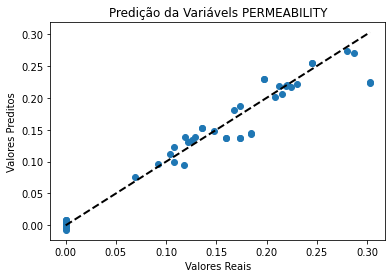

In [578]:
y=y_test
fig, ax = plt.subplots()
ax.scatter(y_Real_PERMEABILITY, y_Predito_PERMEABILITY)
ax.plot([y_Real_PERMEABILITY.min(), y_Real_PERMEABILITY.max()], [y_Real_PERMEABILITY.min(), y_Real_PERMEABILITY.max()], 'k--', lw=2)

ax.set_title('Predição da Variávels PERMEABILITY')
ax.set_xlabel('Valores Reais')
ax.set_ylabel('Valores Preditos')
plt.show()

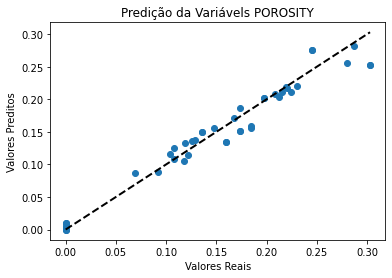

In [579]:
fig, ax = plt.subplots()
ax.scatter(y_Real_POROSITY, y_Predito_POROSITY)
ax.plot([y_Real_POROSITY.min(), y_Real_POROSITY.max()], [y_Real_POROSITY.min(), y_Real_POROSITY.max()], 'k--', lw=2)

ax.set_title('Predição da Variávels POROSITY')
ax.set_xlabel('Valores Reais')
ax.set_ylabel('Valores Preditos')
plt.show()

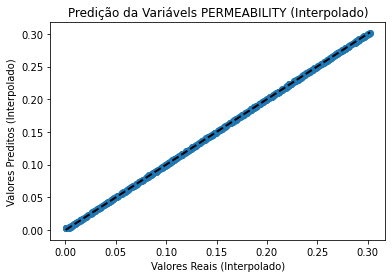

In [580]:
y=y_test_interpolado
fig, ax = plt.subplots()
ax.scatter(y_Real_PERMEABILITY_interpolado, y_Predito_PERMEABILITY_interpolado)
ax.plot([y_Real_PERMEABILITY_interpolado.min(), y_Real_PERMEABILITY_interpolado.max()], [y_Real_PERMEABILITY_interpolado.min(), y_Real_PERMEABILITY_interpolado.max()], 'k--', lw=2)

ax.set_title('Predição da Variávels PERMEABILITY (Interpolado)')
ax.set_xlabel('Valores Reais (Interpolado)')
ax.set_ylabel('Valores Preditos (Interpolado)')
plt.show()

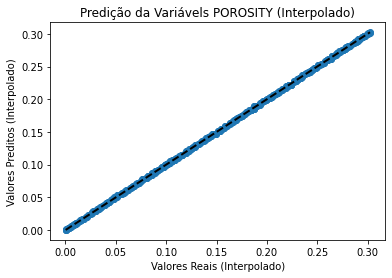

In [581]:
fig, ax = plt.subplots()
ax.scatter(y_Real_POROSITY_interpolado, y_Predito_POROSITY_interpolado)
ax.plot([y_Real_POROSITY_interpolado.min(), y_Real_POROSITY_interpolado.max()], [y_Real_POROSITY_interpolado.min(), y_Real_POROSITY_interpolado.max()], 'k--', lw=2)

ax.set_title('Predição da Variávels POROSITY (Interpolado)')
ax.set_xlabel('Valores Reais (Interpolado)')
ax.set_ylabel('Valores Preditos (Interpolado)')
plt.show()